# Authentication

In [1]:
from google.colab import drive
drive.mount("/gdrive")
%cd "/gdrive"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import os 
os.chdir("/gdrive/MyDrive/work_space/keras_applications")

In [3]:
!ls

cifar10_pytorch.ipynb  mnist_keras.ipynb  save_models
fine_tune_model.ipynb  model.png


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Preprocess Data

In [5]:
import tensorflow as tf 
import keras
from keras.datasets import cifar10

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [7]:
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


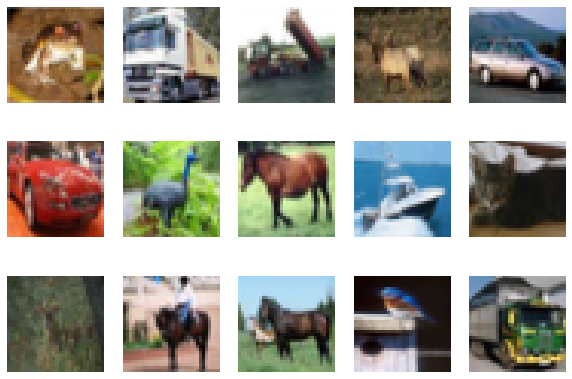

In [8]:
plt.figure(figsize=(10,7))

for i in range(15):
  plt.subplot(3, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis("off")

In [9]:
X_train = X_train.reshape(-1,32, 32, 3 ).astype("float32")
X_test = X_test.reshape(-1,32, 32, 3 ).astype("float32")

X_train /= 255
X_test /=255

In [10]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


# Create Model

In [12]:
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras import layers

from keras import regularizers

INPUT_SHAPE = 32, 32, 3
N_CLASSES = 10

In [13]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [15]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [16]:
model = Sequential()

model.add(conv_base)

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,752,330
Trainable params: 7,117,066
Non-trainable params: 7,635,264
_________________________________________________________________


In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train Model

In [19]:
from keras.callbacks import EarlyStopping

In [20]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [21]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=16, callbacks=[early_stop], validation_data=(X_test, y_test))

Epoch 1/16
782/782 [==============================] - 41s 49ms/step - loss: 1.4023 - accuracy: 0.5206 - val_loss: 1.1199 - val_accuracy: 0.6057
Epoch 2/16
782/782 [==============================] - 37s 47ms/step - loss: 0.9821 - accuracy: 0.6602 - val_loss: 0.9520 - val_accuracy: 0.6666
Epoch 3/16
782/782 [==============================] - 37s 47ms/step - loss: 0.8729 - accuracy: 0.6965 - val_loss: 0.9530 - val_accuracy: 0.6696
Epoch 4/16
782/782 [==============================] - 37s 47ms/step - loss: 0.8067 - accuracy: 0.7191 - val_loss: 0.8638 - val_accuracy: 0.6949
Epoch 5/16
782/782 [==============================] - 37s 48ms/step - loss: 0.7573 - accuracy: 0.7371 - val_loss: 0.8123 - val_accuracy: 0.7154
Epoch 6/16
782/782 [==============================] - 37s 47ms/step - loss: 0.7159 - accuracy: 0.7517 - val_loss: 0.8150 - val_accuracy: 0.7140
Epoch 7/16
782/782 [==============================] - 37s 47ms/step - loss: 0.6802 - accuracy: 0.7636 - val_loss: 0.8074 - val_accuracy:

# Evaluate Model

In [22]:
loss_df = pd.DataFrame(hist.history)
loss_df

,loss,accuracy,val_loss,val_accuracy
0,1.402273,0.52062,1.119882,0.6057
1,0.982100,0.66022,0.952031,0.6666
2,0.872914,0.69648,0.952981,0.6696
3,0.806727,0.71906,0.863822,0.6949
4,0.757289,0.73712,0.812278,0.7154
5,0.715944,0.75174,0.814953,0.7140
6,0.680220,0.76362,0.807393,0.7152
7,0.647941,0.77500,0.839520,0.7069
8,0.618484,0.78518,0.823680,0.7161
9,0.589896,0.79516,0.731443,0.7469


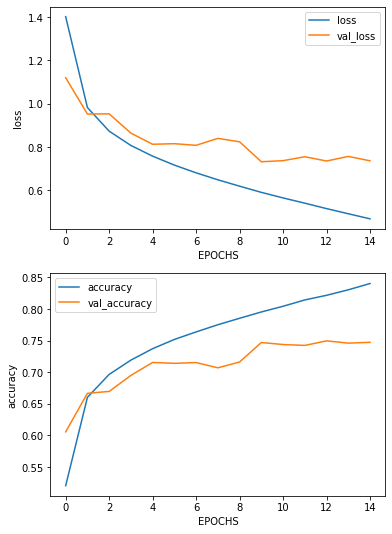

In [23]:
plt.figure(figsize=(6, 9))
plt.subplot(2, 1, 1)
plt.plot(range(len(loss_df)), loss_df["loss"], label="loss")
plt.plot(range(len(loss_df)), loss_df["val_loss"], label="val_loss")
plt.xlabel("EPOCHS")
plt.ylabel("loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(len(loss_df)), loss_df["accuracy"], label="accuracy")
plt.plot(range(len(loss_df)), loss_df["val_accuracy"], label="val_accuracy")
plt.xlabel("EPOCHS")
plt.ylabel("accuracy")
plt.legend()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 7s 20ms/step - loss: 0.7357 - accuracy: 0.7472
